# **Fetch Google Reviews for POIs (Aveiro)**

**Goal:** Build a pipeline to fetch reviews for Points of Interest (POIs) in Aveiro, using:
- **OSM-derived POIs** (from `pois_aveiro.csv`)
- **Google Places API (v1)** for place search and place details (reviews)
- Output to `reviews_output.csv` for downstream **NLP** (sentiment & topic modeling)

> **Note:** Google Places **reviews** are limited to 5 reviews per POI

## 1. Setup & Requirements

**Requirements**
1. A **Google Cloud Project** with **Places API** enabled.
2. A valid **API key**
3. The input file `pois_aveiro.csv` including `geom_pt` (EWKB, SRID=4326) and/or `geom`.

**Environment variables:**
- `GOOGLE_API_KEY`: API key.

In [ ]:
import requests
import time
import os
import pandas as pd
from shapely import wkb

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY", "AIzaSyAwme_k4xStLv2_bLdawdaFAckn55hJ1TNF8L8A")
INPUT_CSV = "../pois_aveiro.csv"
SLEEP_BETWEEN_REQUESTS = 0.25  # seconds to avoid hitting rate limits
RADIUS_METERS = 10  # Search within a 10-meter radius by default
MAX_PLACES_PER_RUN = 20  # Limit the number of places to query

## 2. Helper Functions
Utilities for geometry parsing and API calls.

In [15]:
def ewkb_hex_point_to_lonlat(hex_str: str):
    """
    Convert EWKB hex POINT (SRID=4326) to (lon, lat).
    Many exports store POINT as EWKB hex like '0101000020E6100000...'
    """
    if not isinstance(hex_str, str) or not hex_str:
        return None
    try:
        geom = wkb.loads(bytes.fromhex(hex_str))
        if geom.geom_type == "Point":
            return (geom.x, geom.y)
    except Exception:
        pass
    return None


# Helper Functions for Places API

def places_search_nearby(lat, lon, radius=500, types=["restaurant"]):
    """
    Use Google Places Nearby Search to search for places within a given radius.
    Returns the places found and the API call status.
    """
    url = "https://places.googleapis.com/v1/places:searchNearby"
    payload = {
        "locationRestriction": {
            "circle": {
                "center": {
                    "latitude": lat,
                    "longitude": lon
                },
                "radius": radius
            }
        },
        # "includedTypes": types,
        "maxResultCount":  (MAX_PLACES_PER_RUN or 10),
    }
    params = { 'key': GOOGLE_API_KEY }
    headers = {
        "X-Goog-FieldMask": "places.displayName,places.id,places.reviews,places.location,places.rating,places.primaryType",
        "X-Goog-Api-Key": GOOGLE_API_KEY,
        "Content-Type": "application/json",
    }

    try:
        # Send POST request to the Nearby Search API
        response = requests.post(url, params=params, json=payload, headers=headers, timeout=20)
        time.sleep(SLEEP_BETWEEN_REQUESTS)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Error during API request: {e}")
        return None, "ERROR"
    
    data = response.json()
    places = data.get("places", [])
    return places, "OK" if places else "ZERO_RESULTS"

def process_reviews(reviews):
    """
    Extract the reviews from the response and format them into a list of dictionaries.
    """
    reviews_data = []
    for review in reviews:
        reviews_data.append({
            "author_name": review.get("authorAttribution", {}).get("displayName", "Unknown"),
            "rating": review.get("rating"),
            "review_text": review.get("text", {}).get("text", ""),
            "publish_time": review.get("publishTime"),
        })
    return reviews_data

def get_reviews_for_nearby_places(lat, lon, radius=500):
    """
    Fetch nearby places and their reviews within the specified radius.
    Returns a list of reviews and the status of the operation.
    """
    places, status = places_search_nearby(lat, lon, radius)
    if not places:
        return [], f"No nearby places found. Status: {status}"

    all_reviews = []
    for place in places:
        place_id = place.get("id")
        place_name = place.get("displayName", {}).get("text", "")
        place_location = place.get("location", {})
        place_rating = place.get("rating")
        place_primary_type = place.get("primaryType", "Unknown")
        reviews = place.get("reviews", [])
        processed_reviews = process_reviews(reviews)

        for review in processed_reviews:
            review["place_name"] = place_name
            review["place_id"] = place_id
            review["place_location"] = place_location
            review["place_rating"] = place_rating
            review["place_primary_type"] = place_primary_type
            all_reviews.append(review)

    return all_reviews, "OK"

## 3. Load & Preview POIs
We expect `pois_aveiro.csv` to contain, among many attributes, at least:
- `gid`: unique id
- `amenity` / `shop` / `tourism`: category hints
- `geom_pt` (preferred) or `geom`: EWKB encoded `POINT` (SRID 4326)

In [16]:
pd.set_option("display.max_columns", 60)
try:
    df = pd.read_csv(INPUT_CSV, low_memory=False)
    display(df.head(3))
    print(f"Loaded {len(df)} rows from {INPUT_CSV}")
except FileNotFoundError:
    print(f"WARNING: {INPUT_CSV} not found. Place it next to this notebook.")
    df = pd.DataFrame()

,gid,access,addr:city,addr:country,addr:hamlet,addr:housename,addr:housenumber,addr:municipality,addr:place,addr:postcode,addr:street,addr:suburb,addr:unit,air_conditioning,alt_name,amenity,animal_shelter,architect,architect:wikidata,area,armrest,artist_name,artwork_subject,artwork_type,athletics,atm,attraction,authentication:app,authentication:membership_card,authentication:none,...,toilets:wheelchair,tourism,townhall:type,traffic_calming,traffic_sign,train,tram,unisex,url,valves,vehicle,vending,visibility,washing_machine,waste,water,watermill:disused,website,wetland,wheelchair,wheelchair:description:en,wheelchair:description:pt,width,wifi,wikidata,wikimedia_commons,wikipedia,geom,geom_pt,cat
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0104000020E6100000010000000101000000EBED85B828...,0101000020E6100000EBED85B8287521C025C33B0A2151...,bus_stop
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0104000020E6100000010000000101000000861C5BCF10...,0101000020E6100000861C5BCF101E21C00A720635325C...,stop_position
2,3,NaN,Aveiro,NaN,NaN,NaN,NaN,NaN,NaN,3810-000,"EN 109 Km 57,8",NaN,NaN,NaN,NaN,fuel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,schrader,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0104000020E610000001000000010100000078978BF84E...,0101000020E610000078978BF84E4821C05DCDF055E150...,fuel


Loaded 13258 rows from ../pois_aveiro.csv


## 4. Processing Logic per-POI
For each row:
1. Determine **amenity** (or fallbacks).
2. Parse **coordinates** from `geom_pt` / `geom`.
3. Build a **name hint** from available name columns.
4. **Nearby Search** to fetch place name, place ID, place location, place rating, place type and **reviews** (limited to `MAX_REVIEWS_PER_PLACE`).

In [17]:
def run_pipeline():
    # Load POIs from file
    df = pd.read_csv(INPUT_CSV)

    out_rows = []
    processed = 0

    # Loop over each POI and process reviews
    for idx, row in df.iterrows():
        if processed >= MAX_PLACES_PER_RUN:
            break

        # Get coordinates from 'geom_pt' or 'geom' column
        lonlat = None
        if "geom_pt" in df.columns and isinstance(row.get("geom_pt"), str):
            lonlat = ewkb_hex_point_to_lonlat(row.get("geom_pt"))
            print(lonlat)
        if lonlat is None and "geom" in df.columns and isinstance(row.get("geom"), str):
            lonlat = ewkb_hex_point_to_lonlat(row.get("geom"))

        if not lonlat:
            continue

        lon, lat = lonlat

        # Fetch reviews for the nearby places
        reviews_data, status = get_reviews_for_nearby_places(lat, lon, RADIUS_METERS)

        if reviews_data:
            # Add reviews data to output rows
            for review in reviews_data:
                out_rows.append(review)

        processed += 1

    # Create DataFrame and save to CSV
    if out_rows:
        df_reviews = pd.DataFrame(out_rows)
        df_reviews.to_csv("nearby_reviews.csv", index=False)
        print(f"Saved reviews data to 'nearby_reviews.csv'.")
    else:
        print("No reviews fetched.")
        
    return df_reviews

df_reviews = run_pipeline()
display(df_reviews.head(10))


/tmp/ipykernel_106354/3264769247.py:3: DtypeWarning:

Columns (3,4,5,6,7,8,9,11,12,13,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,142,143,144,145,146,147,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,186,187,188,189,190,191,192,193,194,196,197,198,199,200,201,202,203,204,205,206,207,208,209,211,212,213,214,215,217,220,222,223,224,225,226,227,228,229,230,232,236,237,240,241,242,243,244,245,246,248,249,250,251,252,253,254,256,257,258,259,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,278,279,280,282,283,284,286,287,288,289,290

(-8.7288263, 40.6338208)
(-8.558722, 40.7202822)
(-8.6412275, 40.6318767)
(-8.6303399, 40.6483621)
(-8.6529905, 40.6408293)
(-8.6155501, 40.6530001)
(-8.6302907, 40.6481634)
(-8.6289941, 40.6490393)
(-8.6305762, 40.6464895)
(-8.6398177, 40.6372592)
(-8.6186598, 40.6448436)
(-8.6232773, 40.6425727)
(-8.6553328, 40.6424277)
(-8.643414, 40.6219823)
(-8.6424403, 40.6202283)
(-8.6397822, 40.6160724)
(-8.6556364, 40.6407427)
(-8.6544847, 40.6414747)
(-8.540525, 40.5609636)
(-8.529471, 40.5664656)
Saved reviews data to 'nearby_reviews.csv'.


,author_name,rating,review_text,publish_time,place_name,place_id,place_location,place_rating,place_primary_type
0,Markus Wenger,4,,2024-11-08T10:05:22.566412Z,Avelab - Esgueira,ChIJAQTNSQCZIw0R4oI-HJ_-4rM,"{'latitude': 40.6481978, 'longitude': -8.630289}",4.0,medical_lab
1,Lara Mendes,5,Muito simpáticos! A entrega foi rapidíssima e ...,2025-10-28T20:47:06.519725824Z,EATIN,ChIJ4UYOPL2ZIw0RqgE9nEWdd4M,"{'latitude': 40.648165899999995, 'longitude': ...",5.0,hamburger_restaurant
2,Diogo Moço,5,Encomendei comida para casa e foram rápidos na...,2025-10-28T20:47:48.904490884Z,EATIN,ChIJ4UYOPL2ZIw0RqgE9nEWdd4M,"{'latitude': 40.648165899999995, 'longitude': ...",5.0,hamburger_restaurant
3,Nicole,5,"saboroso, ótima entrega e muito simpáticos",2025-10-24T03:35:24.556694520Z,EATIN,ChIJ4UYOPL2ZIw0RqgE9nEWdd4M,"{'latitude': 40.648165899999995, 'longitude': ...",5.0,hamburger_restaurant
4,José Cândido,5,"O Mercado Gastronômico e Cultural de Aveiro, t...",2025-08-29T13:11:40.256631901Z,Mercado Gstronomico e Cultural,ChIJSSmFEwCZIw0RwqoS59or5Jk,"{'latitude': 40.6424909, 'longitude': -8.6553084}",5.0,market
5,Guilherme Gomes,5,,2025-07-31T14:13:32.213237010Z,Capela de Aradas A,ChIJB6gXebyiIw0RvbrIuITcVoQ,"{'latitude': 40.621984999999995, 'longitude': ...",5.0,bus_stop
6,Christian Efraim Haziel,5,I simply loved it. Best value for money I foun...,2025-07-13T15:31:19.697171341Z,Garden Hostel,ChIJSatg1dyjIw0RkYqArCOLsU0,"{'latitude': 40.6159874, 'longitude': -8.6398687}",3.6,hostel
7,Félix Cloutier,1,It's a forty minutes walk away (3km) from Avei...,2023-05-21T18:55:05.704969Z,Garden Hostel,ChIJSatg1dyjIw0RkYqArCOLsU0,"{'latitude': 40.6159874, 'longitude': -8.6398687}",3.6,hostel
8,Diego andres Camargo,2,I give him two stars for the backyard and the ...,2021-08-12T23:21:10.035467Z,Garden Hostel,ChIJSatg1dyjIw0RkYqArCOLsU0,"{'latitude': 40.6159874, 'longitude': -8.6398687}",3.6,hostel
9,Adarsha আদর্শ シ,4,"Fairly ok for overnight stay, in low price!! ...",2023-08-19T01:33:20.314940Z,Garden Hostel,ChIJSatg1dyjIw0RkYqArCOLsU0,"{'latitude': 40.6159874, 'longitude': -8.6398687}",3.6,hostel


## 5. Graphical Analysis of the Output

In [18]:
import pandas as pd
import ast

csv_path = "nearby_reviews.csv"
df = pd.read_csv(csv_path)

df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['place_rating'] = pd.to_numeric(df['place_rating'], errors='coerce')

def parse_loc(s):
    try:
        return ast.literal_eval(s)
    except Exception:
        return {}
df['place_location'] = df['place_location'].fillna('').apply(parse_loc)
df['lat'] = df['place_location'].apply(lambda x: x.get('latitude'))
df['lon'] = df['place_location'].apply(lambda x: x.get('longitude'))
df['review_length'] = df['review_text'].fillna('').str.len()
df['year_month'] = df['publish_time'].dt.to_period('M')

/tmp/ipykernel_106354/4028166443.py:20: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



## 6. Rating distribution (histogram + kde)
Overall distribution of review ratings (1–5).

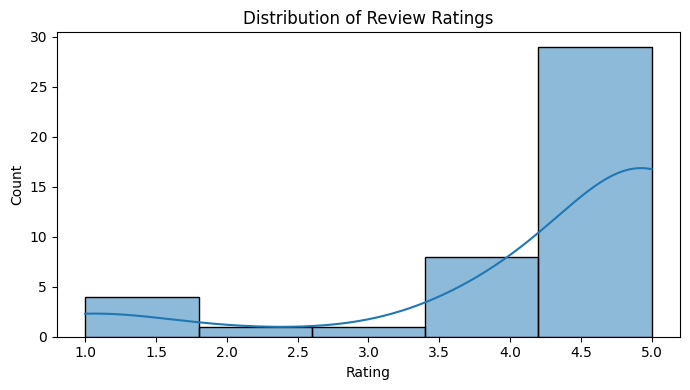

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
sns.histplot(df['rating'].dropna(), bins=5, kde=True)
plt.title("Distribution of Review Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## 7. Reviews per place (top N) — bar chart
Number of reviews per place (top 10 places by count).

/tmp/ipykernel_106354/3900431756.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




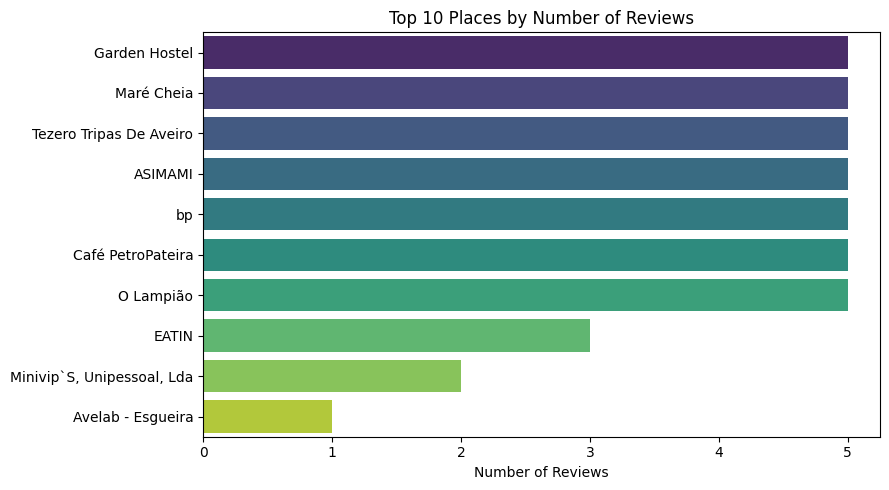

In [20]:
top_places = df['place_name'].value_counts().nlargest(10).reset_index()
top_places.columns = ['place_name','n_reviews']

plt.figure(figsize=(9,5))
sns.barplot(data=top_places, y='place_name', x='n_reviews', palette='viridis')
plt.title("Top 10 Places by Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("")
plt.tight_layout()
plt.show()

## 8. Average review rating per place (top N)
Average user rating per place (show top 10 by review count).

/tmp/ipykernel_106354/2439568483.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




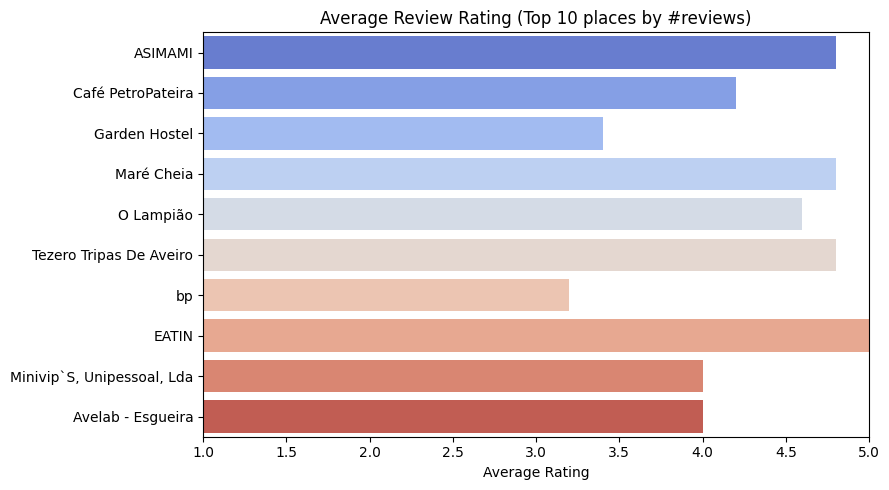

In [21]:
agg = df.groupby('place_name').agg(n_reviews=('rating','count'), mean_rating=('rating','mean')).reset_index()
agg_top = agg.sort_values('n_reviews', ascending=False).head(10)

plt.figure(figsize=(9,5))
sns.barplot(data=agg_top, y='place_name', x='mean_rating', palette='coolwarm')
plt.xlim(1,5)
plt.title("Average Review Rating (Top 10 places by #reviews)")
plt.xlabel("Average Rating")
plt.ylabel("")
plt.tight_layout()
plt.show()

## 9. Place rating (Google) vs average review rating (scatter)
Relationship between place overall rating (place_rating) and the average review rating fetched.

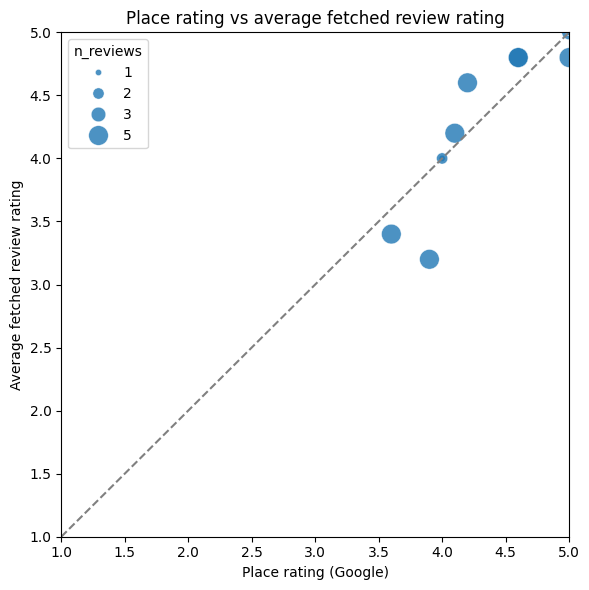

In [22]:
place_stats = df.groupby('place_id').agg(place_name=('place_name','first'),
                                         avg_review_rating=('rating','mean'),
                                         place_rating=('place_rating','first'),
                                         n_reviews=('rating','count')).reset_index()
plt.figure(figsize=(6,6))
sns.scatterplot(data=place_stats, x='place_rating', y='avg_review_rating', size='n_reviews', sizes=(20,200), alpha=0.8)
plt.plot([1,5],[1,5], color='gray', linestyle='--')  # identity
plt.xlabel("Place rating (Google)")
plt.ylabel("Average fetched review rating")
plt.title("Place rating vs average fetched review rating")
plt.xlim(1,5); plt.ylim(1,5)
plt.tight_layout()
plt.show()

## 10. Time series — reviews per month
Volume of reviews over time (monthly).

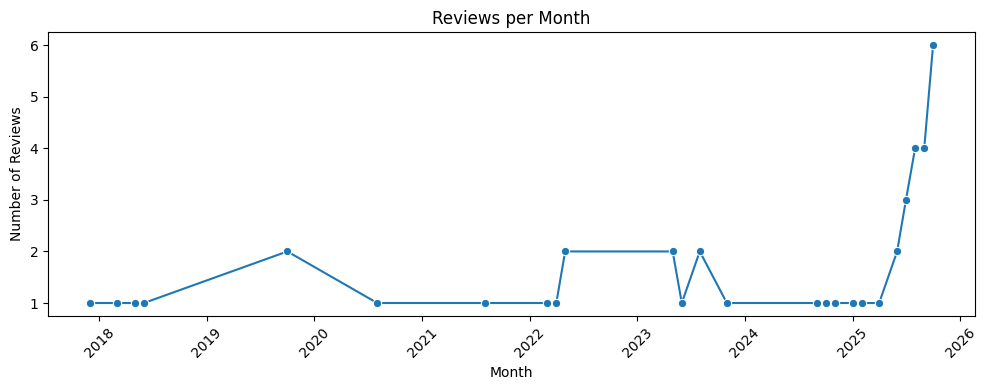

In [23]:
ts = df.groupby('year_month').size().reset_index(name='n_reviews')
ts['year_month'] = ts['year_month'].dt.to_timestamp()

plt.figure(figsize=(10,4))
sns.lineplot(data=ts, x='year_month', y='n_reviews', marker='o')
plt.title("Reviews per Month")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 11. Rating dispersion per place (boxplot / violin)
Show variability of ratings for a few places (choose top 6 by count).

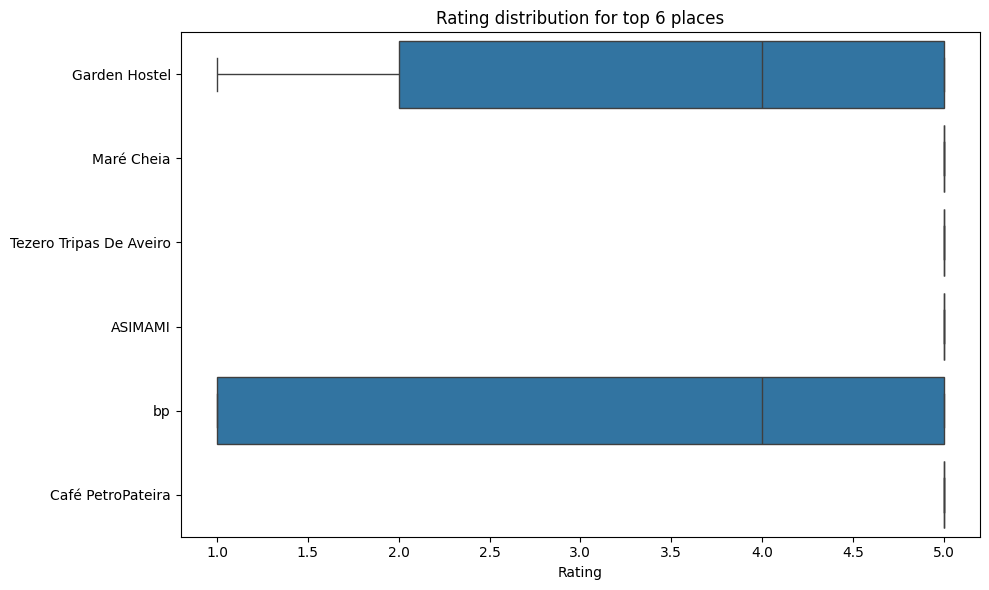

In [24]:
top6 = df['place_name'].value_counts().nlargest(6).index.tolist()
plt.figure(figsize=(10,6))
sns.boxplot(data=df[df['place_name'].isin(top6)], x='rating', y='place_name', showfliers=False)
plt.title("Rating distribution for top 6 places")
plt.xlabel("Rating")
plt.ylabel("")
plt.tight_layout()
plt.show()

## 12. Word cloud — overall or per-place
Visualize most frequent words in reviews (withou cleaned text for now).

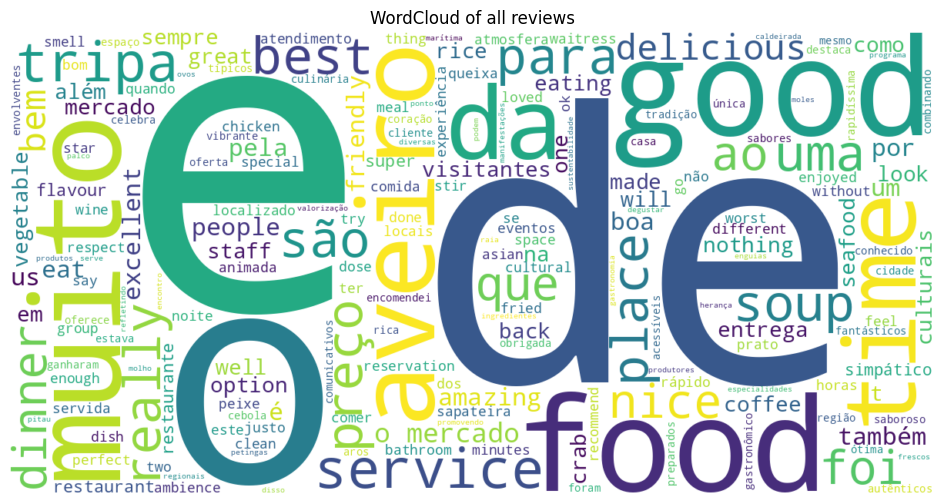

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

def clean_text(s):
    s = re.sub(r'\\W+', ' ', str(s).lower())
    return s

text = " ".join(df['review_text'].dropna().map(clean_text).tolist())
wc = WordCloud(width=1200, height=600, background_color='white', max_words=200).generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of all reviews")
plt.show()